**Рассмотрены 2 подхода прогнозирования временных рядов:**

**1) с помощью авторегрессии AR(p)**

**2) библиотеки от Facebook Prophet**

Везде, если не будет оговорено иное, уровень значимости $\alpha$ будем полагать равным 0.05

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
from fbprophet import Prophet

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
PREDICTIONS = 4

#### Чтение данных

In [5]:
df = pd.read_csv('extra_1.csv',';', parse_dates=True, dayfirst=True)
df['fact'] = df['fact'].astype(float)
df.head(2)

,date,fact,prediction,prev
0,06.05.2015,1.503,-0.117,-0.066
1,13.05.2015,-2.503,0.829,1.503


Посмотрим на данные непосредственно

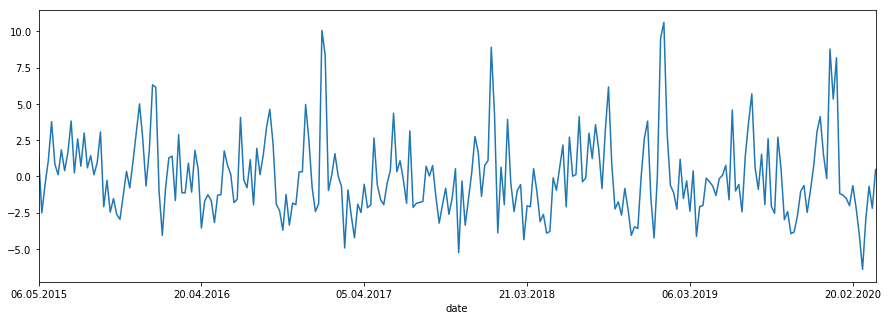

In [6]:
df_ar = df[['date', 'fact']].set_index('date')
plt.figure(figsize(15,5))
df_ar['fact'].plot()
plt.show()

Наблюдается сезонность (данные еженедельные), проверим критерием Дики-Фуллера на нестационарность

In [7]:
print(f"Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(df_ar['fact'], maxlag=60)[1]}")

Критерий Дики-Фуллера: p = 0.24755537167261732


На уровне значимости $\alpha$ гипотеза о нестационарности принимается. Попробуем продифференцировать ряд

In [8]:
#отрежем последний месяц из данных для дальнейшего его предсказания
future = df_ar.iloc[-PREDICTIONS:,:].copy()
df_ar = df_ar.iloc[:-PREDICTIONS, :].copy()

Критерий Дики-Фуллера: p = 0.0003069777945688195


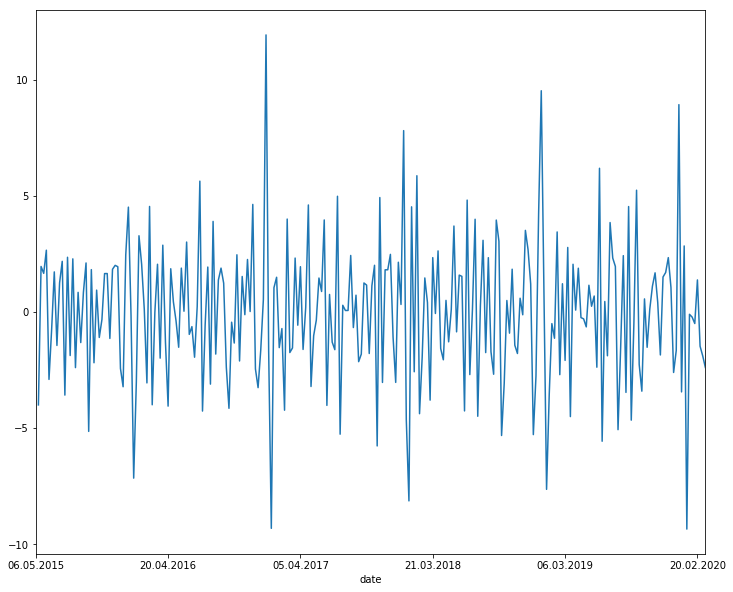

In [9]:
df_ar['fact_diff'] = df_ar['fact'] - df_ar['fact'].shift(1)
plt.figure(figsize(12,10))
df_ar['fact_diff'].plot()
print(f"Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(df_ar['fact_diff'][1:], maxlag=60)[1]}")

Гипотеза о нестационарности отвергается на заданном уровне значимости $\alpha$. Наблюдаются некоторые выбросы в данных, что приводит к некоторой нестационарности дисперсии всего ряда, но в целом, на мой взгляд, по графику ряд выглядит, как стационарный.

## Подбор AR(p) модели

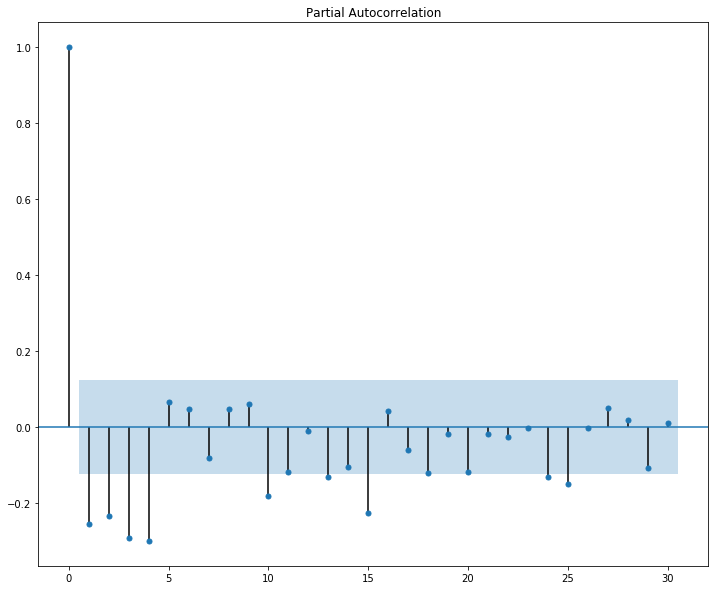

In [10]:
sm.graphics.tsa.plot_pacf(df_ar['fact_diff'][1:].values.squeeze(), lags=30)
pylab.show()

In [11]:
ps = range(0, 4)
d = 1
q = 0
Ps = range(0, 2)
Ds = range(0, 2)
Q = 0

In [12]:
from itertools import product
parameters = product(ps, Ps, Ds)
parameters_list = list(parameters)
len(parameters_list)

16

Построим AR модели по полученным комбинациям параметров и посчитаем у каждой из них критерий Акаике (AIC) для отбора лучших моделей.

In [13]:
results = []
for param in parameters_list:
    model = sm.tsa.statespace.SARIMAX(df_ar['fact'], order=(param[0], 1, 0), 
                                      seasonal_order=(param[1], param[2] , 0, 52)).fit(disp=False, maxiter=1000)
    results.append([param[0], 1, 0, param[1], param[2], 0, model.aic])

Топ-5 моделей по критерию Акаике

In [14]:
result_table = pd.DataFrame(results, columns=['p', 'd', 'q', 'P', 'D', 'Q', 'aic'])
result_table = result_table.sort_values(by = 'aic', ascending=True)
print(result_table.head())

    p  d  q  P  D  Q          aic
15  3  1  0  1  1  0   959.726998
11  2  1  0  1  1  0   968.010829
7   1  1  0  1  1  0   973.055687
13  3  1  0  0  1  0  1000.318335
9   2  1  0  0  1  0  1009.142980


Возьмем лучшую модель

In [15]:
params = result_table.iloc[0, :]
ar_model = sm.tsa.statespace.SARIMAX(df_ar['fact'], order=(params[0], 1, 0), 
                                      seasonal_order=(params[1], params[2] , 0, 52)).fit(disp=False, maxiter=1000)

## Прогноз по полученной AR(p) модели

In [16]:
#обратно соединим два датафрейма для прогнозирования
df_ar = pd.concat([df_ar, future])

date_list = df_ar[-PREDICTIONS:].index
df_out = pd.DataFrame(columns=['ar_pred', 'fact'], index=date_list)
df_out['ar_pred'] = ar_model.predict(start=len(df_ar)-PREDICTIONS, end=len(df_ar)-1).tolist()
df_out['fact'] = df_ar.iloc[-PREDICTIONS:, 0]

In [17]:
mse = np.mean((df_out.loc[:, 'ar_pred'] - df_out.loc[:, 'fact'])**2)
print(f"Накопленный квадрат ошибок: {mse}")

Накопленный квадрат ошибок: 14.543403314428044


## Prophet

In [18]:
dates = [pd.to_datetime(x, format='%d.%m.%Y') for x in df['date']]
min(dates), max(dates)

(Timestamp('2015-05-06 00:00:00'), Timestamp('2020-04-08 00:00:00'))

In [19]:
#подготовка датафрейма
df_prop = df[['date', 'fact']].copy()
df_prop['date'] = pd.Series(pd.date_range('5/6/2015', '4/15/2020', freq='W')).values
df_prop = df_prop.rename(columns={'date': 'ds', 'fact': 'y'})

train_df = df_prop[:-PREDICTIONS].copy()

In [20]:
prop_model = Prophet(weekly_seasonality=True)
prop_model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
future = prop_model.make_future_dataframe(periods=PREDICTIONS, freq='W')
forecast = prop_model.predict(future)

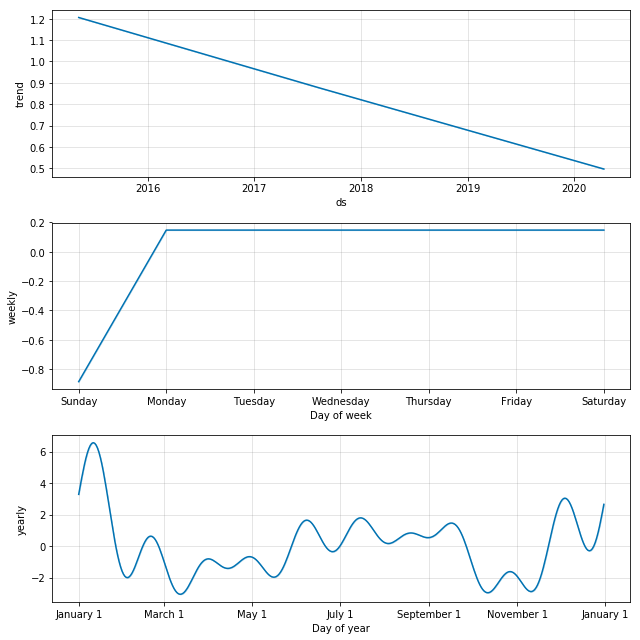

In [22]:
prop_model.plot_components(forecast)
plt.show()

In [23]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_prop.set_index('ds'))
cmp_df.head(1)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-05-10,-1.157068,-3.511252,1.274038,1.503


In [24]:
mse = np.mean((cmp_df.iloc[-PREDICTIONS:, 0] - cmp_df.iloc[-PREDICTIONS:, 3])**2)
print(f"Накопленный квадрат ошибок: {mse}")

Накопленный квадрат ошибок: 1.6673721430707455


## Построим совместные графики с предсказаниями

In [25]:
data = pd.DataFrame(columns = ['ar_pred', 'prophet', 'fact'], index=date_list)
data['ar_pred'] = df_out['ar_pred'].values
data['fact'] = df_out['fact'].values
data['prophet'] = cmp_df.iloc[-PREDICTIONS:, 0].values

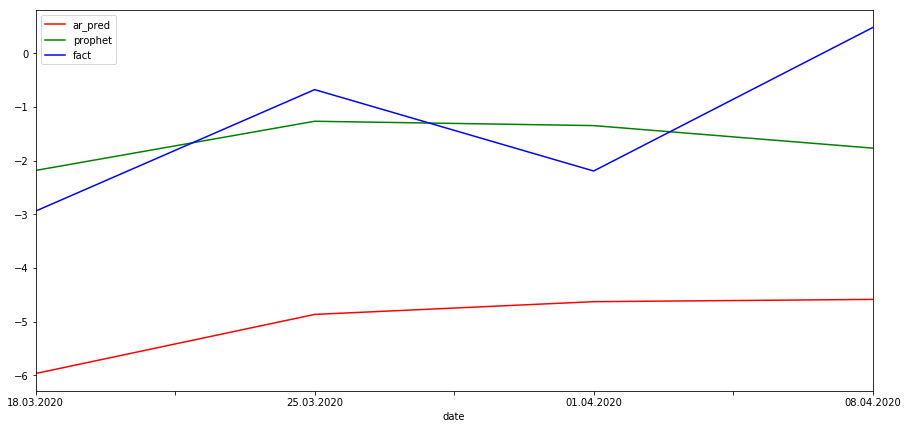

In [26]:
plt.figure(figsize(15,7))

data['ar_pred'].plot(color='r')
data['prophet'].plot(color='g')
data['fact'].plot(color='b')
plt.legend(loc='best')

## А также графики накопленных квадартов ошибок

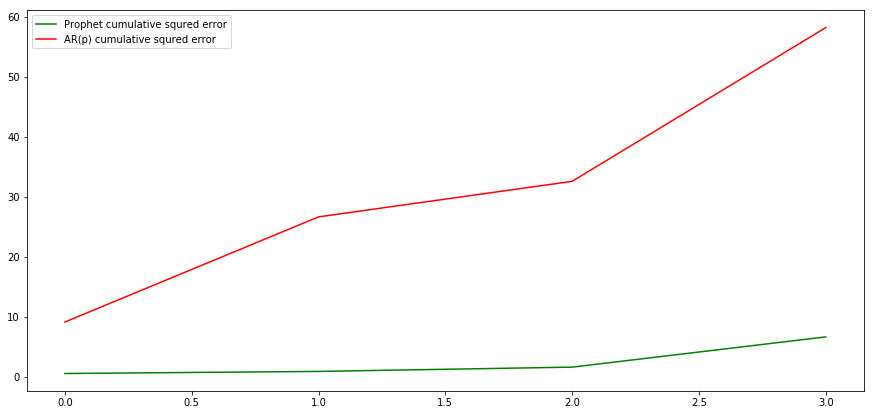

In [32]:
plt.plot(np.cumsum((cmp_df.iloc[-PREDICTIONS:, 0] - cmp_df.iloc[-PREDICTIONS:, 3])**2).values, color='g'
        , label='Prophet cumulative squred error')
plt.plot(np.cumsum((df_out.loc[:, 'ar_pred'] - df_out.loc[:, 'fact'])**2).values, color='r'
        , label='AR(p) cumulative squred error')
plt.legend(loc='best');

## Вывод:
Модель prophet предсказывает на порядок лучше на данном временном ряде с заданным интервалом предсказания, что видно исходя из накопленного квадрата ошибок как в численном, так и в графическом виде, а также из вида кривых предсказаний и истинного значения.

В задаче предсказывается временной ряд на месяц на недельных данных

P.S При изменении интервала предсказания (PREDICTIONS) на бОльшие значения, prophet предсказывает все еще лучше, но из-за бОльшего числа точек предсказания AR модель проигрывает меньше, судя по накопленному квадрату ошибок.